In [1]:
pip install librosa pydub speechrecognition numpy pandas matplotlib seaborn scikit-learn transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 15.9 MB/s eta 0:00:00


In [4]:
import librosa
import librosa
import numpy as np

def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    return y, sr


In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import speech_recognition as sr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re

In [7]:
file_path = '/content/harvard.wav'
y, sr_ = librosa.load(file_path, sr=None)


In [12]:
def extract_audio_features(y, sr_):
    duration = librosa.get_duration(y=y, sr=sr_)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr_)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr_)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    pitch_var = np.std(pitch_values)

    # Silence detection
    intervals = librosa.effects.split(y, top_db=30)
    pauses = len(intervals)
    speech_rate = len(intervals) / duration

    return {
        "duration_sec": duration,
        "tempo": tempo,
        "pitch_variability": pitch_var,
        "pauses": pauses,
        "speech_rate": speech_rate
    }


In [14]:
features = extract_audio_features(y, sr_)
print("Extracted Audio Features:", features)

Extracted Audio Features: {'duration_sec': 18.356190476190477, 'tempo': array([107.66601562]), 'pitch_variability': np.float32(1150.8677), 'pauses': 43, 'speech_rate': 2.342533983604856}


In [15]:
recognizer = sr.Recognizer()
with sr.AudioFile(file_path) as source:
    audio_data = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        text = "[Unrecognized speech]"

print("Transcript:", text)

Transcript: does snail smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun


In [16]:
# 3. NLP-based Features
def extract_text_features(text):
    words = text.split()
    hesitations = len([w for w in words if w.lower() in ["um", "uh", "erm"]])
    word_count = len(words)
    hesitation_rate = hesitations / word_count if word_count else 0

    incomplete_sentences = len(re.findall(r'[^\.\!\?]$', text)) > 0
    return {
        "word_count": word_count,
        "hesitation_markers": hesitations,
        "hesitation_rate": hesitation_rate,
        "incomplete_sentences": int(incomplete_sentences)
    }

text_features = extract_text_features(text)
print("Text-Based Features:", text_features)

Text-Based Features: {'word_count': 43, 'hesitation_markers': 0, 'hesitation_rate': 0.0, 'incomplete_sentences': 1}


In [18]:
# 4. Combine All Features for Modeling
import numpy as np

all_features = {**features, **text_features}

# Convert all values to numeric types if possible
# Check for nested structures (lists, arrays) and flatten them
numeric_features = []
for value in all_features.values():
    if isinstance(value, (int, float)):
        numeric_features.append(value)
    elif isinstance(value, (list, np.ndarray)):
        numeric_features.extend(value)  # Flatten nested structures
    else:
        try:
            numeric_features.append(float(value))  # Try converting to float
        except (ValueError, TypeError):
            print(f"Skipping feature: {value} (Non-numeric type)")

# Create NumPy array from the numeric features
X = np.array(numeric_features).reshape(1, -1)

In [19]:
X_sim = np.vstack([X + np.random.normal(0, 0.05, X.shape) for _ in range(10)])

In [20]:
# 5. Clustering for Cognitive Risk Detection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sim)

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [22]:
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(X_scaled)

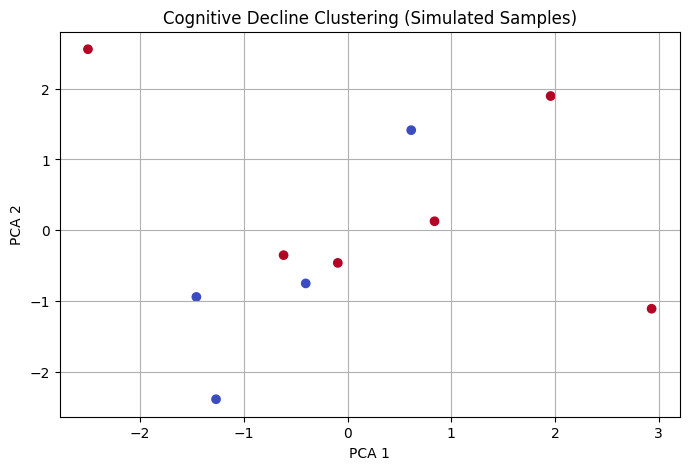

In [23]:
# 6. Visualize Results
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm')
plt.title("Cognitive Decline Clustering (Simulated Samples)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()
